In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

### Load image

In [2]:
dataset_path = 'data'

train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

# image size
img_h = 128
img_w = 128

In [3]:
# image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# rescale image
train_datagen = ImageDataGenerator(rescale = 1./255,)
test_datagen = ImageDataGenerator(rescale = 1./255,)
valid_datagen = ImageDataGenerator(rescale = 1./255,)

# load image
train_gen = train_datagen.flow_from_directory(train_path, 
                                              target_size=(img_h, img_w),
                                              color_mode='rgb',
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              shuffle = True,
                                              seed = 42
                                              )

test_gen = test_datagen.flow_from_directory(test_path, 
                                              target_size=(img_h, img_w),
                                              color_mode='rgb',
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              shuffle = False,
                                              seed = 42
                                              )

valid_gen = valid_datagen.flow_from_directory(valid_path, 
                                              target_size=(img_h, img_w),
                                              color_mode='rgb',
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              shuffle = True,
                                              seed = 42
                                              )

Found 2379 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


### CNN

#### Model creation

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [6]:
input_shape = train_gen.image_shape
num_classes = 15

model = keras.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0

#### Model Trainning

In [14]:
epochs = 500

callback = EarlyStopping(monitor='val_loss', patience=3) # prevent overfitting

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
model_his = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callback)

Epoch 1/500
75/75 [==============================] - 138s 2s/step - loss: 189.9815 - precision_2: 0.3156 - recall_2: 0.3140 - accuracy: 0.3140 - val_loss: 103.5959 - val_precision_2: 0.0800 - val_recall_2: 0.0800 - val_accuracy: 0.0800
Epoch 2/500
75/75 [==============================] - 128s 2s/step - loss: 57.1483 - precision_2: 0.5235 - recall_2: 0.5233 - accuracy: 0.5237 - val_loss: 82.6647 - val_precision_2: 0.0667 - val_recall_2: 0.0667 - val_accuracy: 0.0667
Epoch 3/500
75/75 [==============================] - 125s 2s/step - loss: 39.1913 - precision_2: 0.6049 - recall_2: 0.6049 - accuracy: 0.6049 - val_loss: 75.9789 - val_precision_2: 0.1600 - val_recall_2: 0.1600 - val_accuracy: 0.1600
Epoch 4/500
75/75 [==============================] - 126s 2s/step - loss: 22.3409 - precision_2: 0.6662 - recall_2: 0.6662 - accuracy: 0.6662 - val_loss: 81.7104 - val_precision_2: 0.2400 - val_recall_2: 0.2400 - val_accuracy: 0.2400
Epoch 5/500
75/75 [==============================] - 129s 2s/s

In [15]:
model.save('brid_classification_model.h5')

In [95]:
#model = keras.models.load_model('brid_classification_model.h5')

In [16]:
model_score = model.evaluate(test_gen, verbose=0)
print('Train accuracy:{}'.format(model_his.history['accuracy'][-1]))
print('Test accuracy:{}'.format(model_score[-1]))

Train accuracy:0.8469945192337036
Test accuracy:0.7333333492279053


### ResNet50

#### Model creation

In [17]:
from tensorflow.keras.applications import ResNet50

model_resnet50 = keras.Sequential()

model_resnet50.add(ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape,
    pooling = 'avg',
))

model_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
model_resnet50.layers[0].trainable = False

In [19]:
model_resnet50.add(layers.Flatten())
model_resnet50.add(layers.Dense(512, activation='relu'))
model_resnet50.add(layers.Dropout(0.5))
model_resnet50.add(layers.Dense(num_classes, activation='softmax'))

#### Model Trainning

In [20]:
epochs = 500

callback = EarlyStopping(monitor='val_loss', patience=3) # prevent overfitting

model_resnet50.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_resnet50_his = model_resnet50.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callback)

Epoch 1/500
75/75 [==============================] - 53s 657ms/step - loss: 2.7456 - accuracy: 0.0963 - val_loss: 2.6623 - val_accuracy: 0.1067
Epoch 2/500
75/75 [==============================] - 51s 677ms/step - loss: 2.6082 - accuracy: 0.1572 - val_loss: 2.5632 - val_accuracy: 0.1467
Epoch 3/500
75/75 [==============================] - 46s 608ms/step - loss: 2.5380 - accuracy: 0.1816 - val_loss: 2.4948 - val_accuracy: 0.1600
Epoch 4/500
75/75 [==============================] - 44s 592ms/step - loss: 2.4679 - accuracy: 0.1976 - val_loss: 2.4178 - val_accuracy: 0.2133
Epoch 5/500
75/75 [==============================] - 42s 557ms/step - loss: 2.4040 - accuracy: 0.2303 - val_loss: 2.3703 - val_accuracy: 0.2400
Epoch 6/500
75/75 [==============================] - 44s 585ms/step - loss: 2.3323 - accuracy: 0.2488 - val_loss: 2.3389 - val_accuracy: 0.2133
Epoch 7/500
75/75 [==============================] - 42s 557ms/step - loss: 2.2921 - accuracy: 0.2488 - val_loss: 2.2711 - val_accuracy:

In [15]:
resnet50_test_loss, resnet50_test_accuracy = model_resnet50.evaluate(test_gen, verbose=0)
print('ResNet50 Test loss:{}'.format(resnet50_test_loss))
print('ResNet50 Test accuracy:{}'.format(resnet50_test_accuracy))

ResNet50 Test loss:2.6602392196655273
ResNet50 Test accuracy:0.06666667014360428


In [21]:
model_resnet50.save('brid_classification_model_resnet50.h5')

#### Model evaluation functions

In [23]:
def report(model_name):

    from sklearn.metrics import classification_report

    predict = model_name.predict(test_gen)
    pred = np.argmax(predict, axis=-1)
    true_class = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    report = classification_report(true_class, pred, target_names=class_labels)
    print(report)

In [24]:
def confusion_matrix_plot(model_name):

    from sklearn.metrics import confusion_matrix

    predict = model_name.predict(test_gen)
    pred = np.argmax(predict, axis=-1)
    true_class = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    confu = confusion_matrix(true_class, pred)

    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(confu, annot=True, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    plt.ylabel('True species')
    plt.xlabel('Predicted species')

In [25]:
def accuracy_loss_plot(model_history_name):

    accu_line = model_history_name.history['accuracy']
    val_accu_line = model_history_name.history['val_accuracy']
    loss_line = model_history_name.history['loss']
    val_loss_line = model_history_name.history['val_loss']

    fig, axs = plt.subplots(1,2, figsize=(15,5))

    axs[0].plot(accu_line)
    axs[0].plot(val_accu_line)
    axs[0].set_title('Model accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Accuray', 'Val_accuracy'])


    axs[1].plot(loss_line)
    axs[1].plot(val_loss_line)
    axs[1].set_title('Model loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Loss', 'Val_loss'])

### Model evaluation - accuracy_loss plot, classificaiton report, confusion matrix

CNN model evaluation

In [26]:
report(model)

3/3 [==============================] - 1s 274ms/step
                       precision    recall  f1-score   support

    AMERICAN FLAMINGO       0.60      0.60      0.60         5
   AMERICAN GOLDFINCH       1.00      1.00      1.00         5
           BALD EAGLE       0.71      1.00      0.83         5
             BARN OWL       0.80      0.80      0.80         5
    BELTED KINGFISHER       0.80      0.80      0.80         5
           BLACK SWAN       0.75      0.60      0.67         5
     DOWNY WOODPECKER       1.00      0.80      0.89         5
     EASTERN BLUEBIRD       0.71      1.00      0.83         5
          HOUSE FINCH       1.00      0.40      0.57         5
        HOUSE SPARROW       1.00      0.80      0.89         5
         MALLARD DUCK       0.75      0.60      0.67         5
         MANDRIN DUCK       1.00      0.60      0.75         5
    NORTHERN CARDINAL       0.29      0.80      0.42         5
               OSPREY       1.00      0.60      0.75         5
R

3/3 [==============================] - 1s 204ms/step


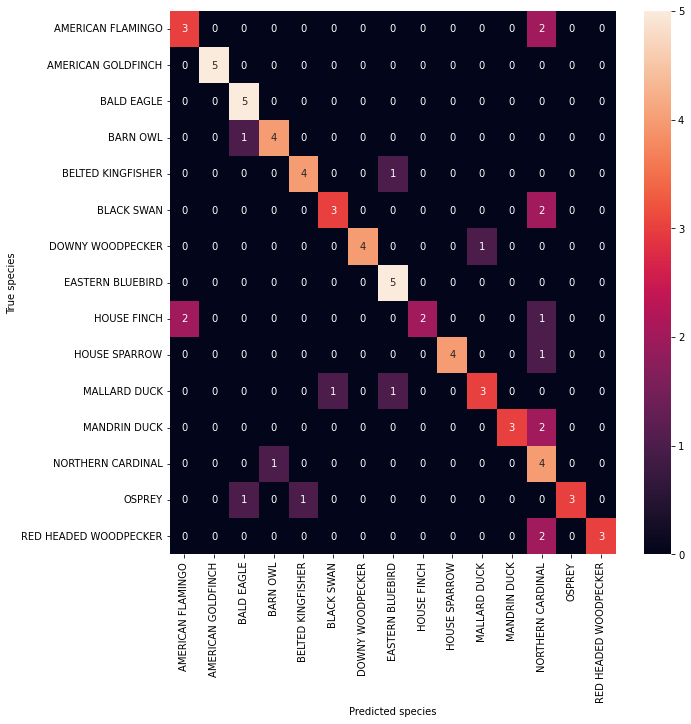

In [27]:
confusion_matrix_plot(model)

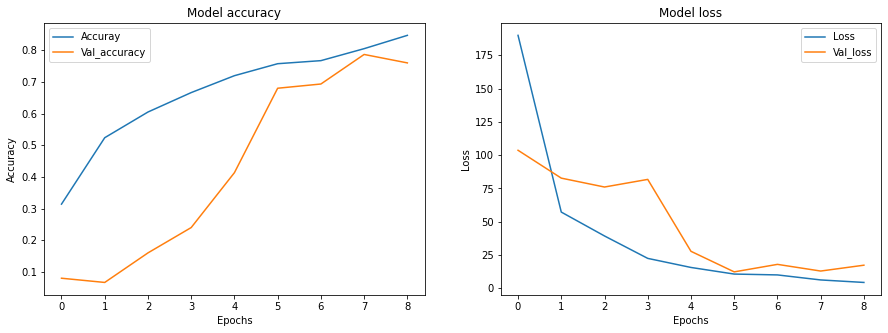

In [28]:
accuracy_loss_plot(model_his)

#### ResNet50 evaluation

In [29]:
report(model_resnet50)

3/3 [==============================] - 3s 384ms/step
                       precision    recall  f1-score   support

    AMERICAN FLAMINGO       0.33      0.20      0.25         5
   AMERICAN GOLDFINCH       0.50      0.20      0.29         5
           BALD EAGLE       0.50      0.60      0.55         5
             BARN OWL       0.50      0.20      0.29         5
    BELTED KINGFISHER       0.62      1.00      0.77         5
           BLACK SWAN       0.67      0.80      0.73         5
     DOWNY WOODPECKER       1.00      0.80      0.89         5
     EASTERN BLUEBIRD       0.00      0.00      0.00         5
          HOUSE FINCH       0.18      0.80      0.30         5
        HOUSE SPARROW       0.50      0.20      0.29         5
         MALLARD DUCK       1.00      0.80      0.89         5
         MANDRIN DUCK       0.67      0.80      0.73         5
    NORTHERN CARDINAL       0.00      0.00      0.00         5
               OSPREY       0.40      0.40      0.40         5
R

c:\Users\rusy_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rusy_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rusy_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 368ms/step


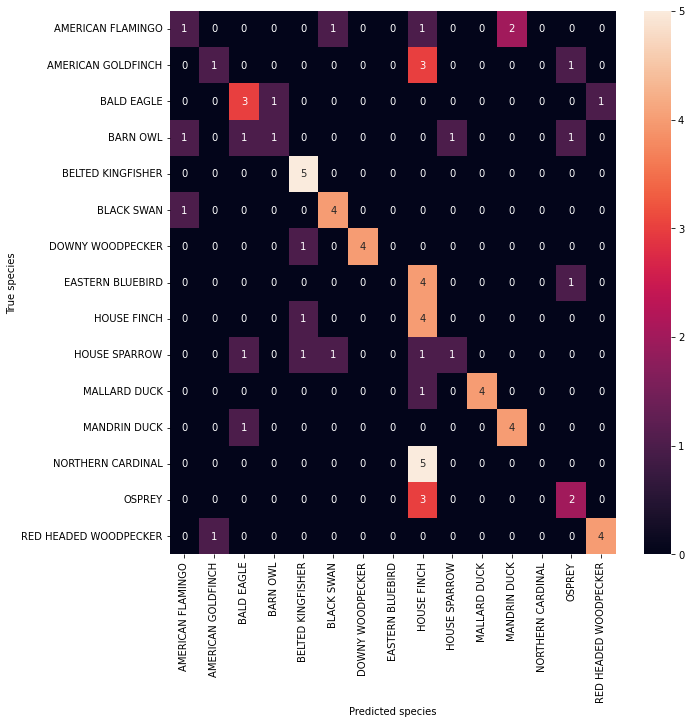

In [30]:
confusion_matrix_plot(model_resnet50)

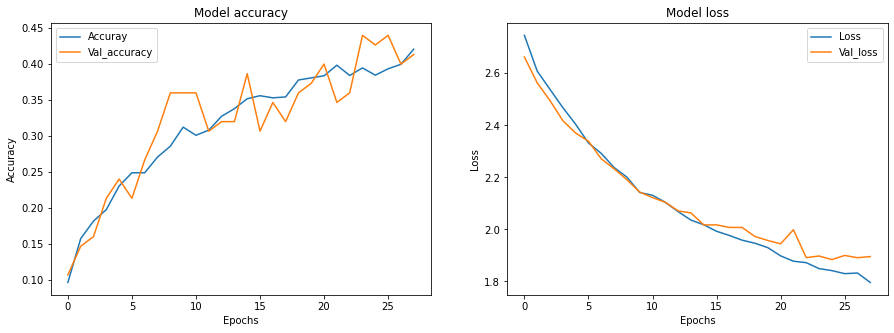

In [31]:
accuracy_loss_plot(model_resnet50_his)